In [1]:
import pandas as pd
import numpy as np
from nptdms import TdmsFile
from pathlib import Path
import os
import matplotlib.pyplot as plt

# Path to the directory containing TDMS files
tdms_dir = r"C:\Users\patry\OneDrive\Pulpit\testv2"

# List to store paths of TDMS files
tdms_list = []

# Walk through the directory and its subdirectories
for root, dirs, files in os.walk(tdms_dir):
    print(f"There are {len(dirs)} directories and {len(files)} file in {root}")
    
    for file in files:
        if file.endswith(".tdms"):
            # If the file ends with '.tdms', add its full path to the list
            tdms_list.append(os.path.join(root, file))

There are 0 directories and 1 file in C:\Users\patry\OneDrive\Pulpit\testv2


In [2]:
# Create an empty list to store data
data_list = []

# Open tdms files and create a list with labels
for tdms_file_path in tdms_list:
    tdms_file = TdmsFile.read(tdms_file_path)
    first_letter = os.path.basename(tdms_file_path)[0]
    
    for group in tdms_file.groups():
        for channel in group.channels():
            data_len = np.shape(channel.data)[0]
            # Check conditions and append data to list
            if (data_len <= 1000000 and data_len >= 10000 and first_letter != 'z'):
                data_list.append({
                    #'anchor_ids': group.name,
                    'class': first_letter,
                    #'driveway': channel.name,
                    'excitation': channel.data,
                    'type_id': 1 if first_letter == 'd' else 0
                })

# Create DataFrame from the list of dictionaries
df = pd.DataFrame(data_list)

In [3]:
df_date = df.loc[df.index % 2 == 0]
df_magitude = df.loc[df.index % 2 != 0]

In [4]:
df_magitude.head()

,class,excitation,type_id
1,D,"[-0.49908613000000024, 1.0268593800000012, 0.8...",0
3,D,"[0.3049820260000011, 0.14633466400000117, 0.52...",0
5,D,"[-0.13177607299999927, -0.01836550899999878, -...",0
7,D,"[-0.25442513799999844, -0.019321215999999808, ...",0
9,D,"[0.1383704390000009, 0.41425119300000013, 0.21...",0


In [5]:
from scipy.signal import welch

def signal_to_psd(signal: np.array, sampling_rate: float) -> tuple:
    """
    Computes the Power Spectral Density (PSD) using Welch's method for the given signal.

    Parameters:
    signal (np.array): Input signal.
    sampling_rate (float): Sampling frequency of the signal (samples per second).

    Returns:
    tuple: A tuple containing the PSD result and corresponding frequencies.
    """
    frequencies, psd = welch(signal, fs=sampling_rate)
    return frequencies, psd

In [6]:
# Determine the maximum length of the signals
max_length = max(df_magitude['excitation'].apply(len))

# Zero-pad each signal to the maximum length
padded_signals = df_magitude['excitation'].apply(lambda x: np.pad(x, (0, max_length - len(x)), 'constant'))

# Initialize the new DataFrame
df_fft = pd.DataFrame()

# Copy the 'type_id' column from df_magitude
df_fft['type_id'] = df_magitude['type_id']

# Initialize empty lists to store the frequencies and magnitudes
freq_list = []
magni_list = []

# Compute FFT for each zero-padded signal
for signal in padded_signals:
    freq, magni = signal_to_psd(np.array(signal), 40000)  # Assuming a sampling rate of 1 Hz
    freq_list.append(freq)
    magni_list.append(magni)

# Add the computed frequencies and magnitudes to the new DataFrame
df_fft['frequencies'] = freq_list
df_fft['magnitudes'] = magni_list

In [7]:
df_fft.head()

,type_id,frequencies,magnitudes
1,0,"[0.0, 156.25, 312.5, 468.75, 625.0, 781.25, 93...","[4.520471330490741e-08, 7.393750037584636e-08,..."
3,0,"[0.0, 156.25, 312.5, 468.75, 625.0, 781.25, 93...","[6.369409267038734e-09, 4.081007033312175e-09,..."
5,0,"[0.0, 156.25, 312.5, 468.75, 625.0, 781.25, 93...","[1.141140564467362e-08, 2.524108667613988e-08,..."
7,0,"[0.0, 156.25, 312.5, 468.75, 625.0, 781.25, 93...","[7.087116495286038e-09, 4.172489314437791e-09,..."
9,0,"[0.0, 156.25, 312.5, 468.75, 625.0, 781.25, 93...","[1.1295733781644811e-08, 2.3453340442339188e-0..."


In [8]:
import numpy as np
from scipy.signal import spectrogram

def make_spectrogram(signal: np.array, sampling_rate: int = 40000) -> np.array:
    """
    Computes the spectrogram for the given signal and returns its numerical representation.

    Parameters:
    signal (np.array): Input signal.
    sampling_rate (int): Sampling frequency of the signal (samples per second). Default is 40000 Hz.

    Returns:
    np.array: Numerical representation of the spectrogram in the format (height, width, color_channel).
    """
    frequencies, times, Sxx = spectrogram(signal, fs=sampling_rate)
    
    Sxx_db = 10 * np.log10(Sxx + 1e-8)  # Dodajemy małą wartość, aby uniknąć log(0)
    
    # Normalizujemy wartości spektrogramu do zakresu 0-255
    normalized_spectrogram = ((Sxx_db - Sxx_db.min()) / (Sxx_db.max() - Sxx_db.min())) * 255
    
    # Tworzymy obraz z wartości spektrogramu w formacie (x, y, kanał_koloru)
    spectrogram_image = np.stack((normalized_spectrogram,) * 3, axis=-1).astype(np.uint8)
    
    return spectrogram_image

In [9]:
import cv2

spectogram_list = []

for signal in padded_signals:
    Sxx_db = make_spectrogram(signal)
    Sxx_db = cv2.resize(Sxx_db, (100, 100))
    spectogram_list.append(Sxx_db)

df_fft['spectrogram'] = spectogram_list

In [10]:
df_fft.head()

,type_id,frequencies,magnitudes,spectrogram
1,0,"[0.0, 156.25, 312.5, 468.75, 625.0, 781.25, 93...","[4.520471330490741e-08, 7.393750037584636e-08,...","[[[63, 63, 63], [28, 28, 28], [61, 61, 61], [0..."
3,0,"[0.0, 156.25, 312.5, 468.75, 625.0, 781.25, 93...","[6.369409267038734e-09, 4.081007033312175e-09,...","[[[22, 22, 22], [11, 11, 11], [43, 43, 43], [1..."
5,0,"[0.0, 156.25, 312.5, 468.75, 625.0, 781.25, 93...","[1.141140564467362e-08, 2.524108667613988e-08,...","[[[33, 33, 33], [34, 34, 34], [42, 42, 42], [6..."
7,0,"[0.0, 156.25, 312.5, 468.75, 625.0, 781.25, 93...","[7.087116495286038e-09, 4.172489314437791e-09,...","[[[63, 63, 63], [13, 13, 13], [32, 32, 32], [4..."
9,0,"[0.0, 156.25, 312.5, 468.75, 625.0, 781.25, 93...","[1.1295733781644811e-08, 2.3453340442339188e-0...","[[[79, 79, 79], [29, 29, 29], [49, 49, 49], [4..."


In [11]:
len(df_fft)

48

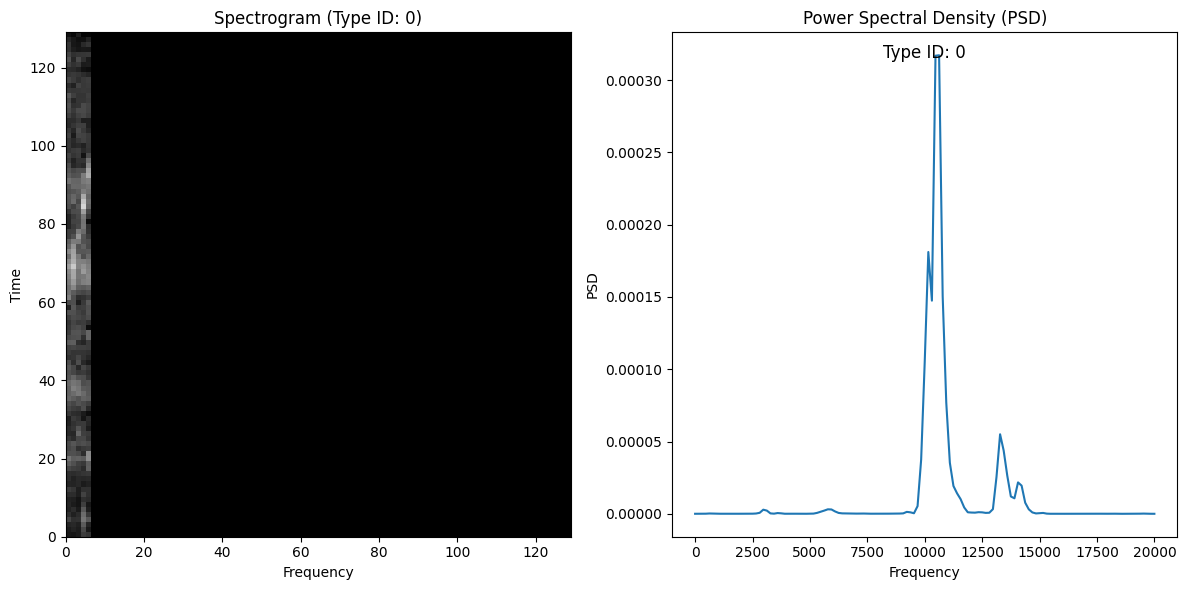

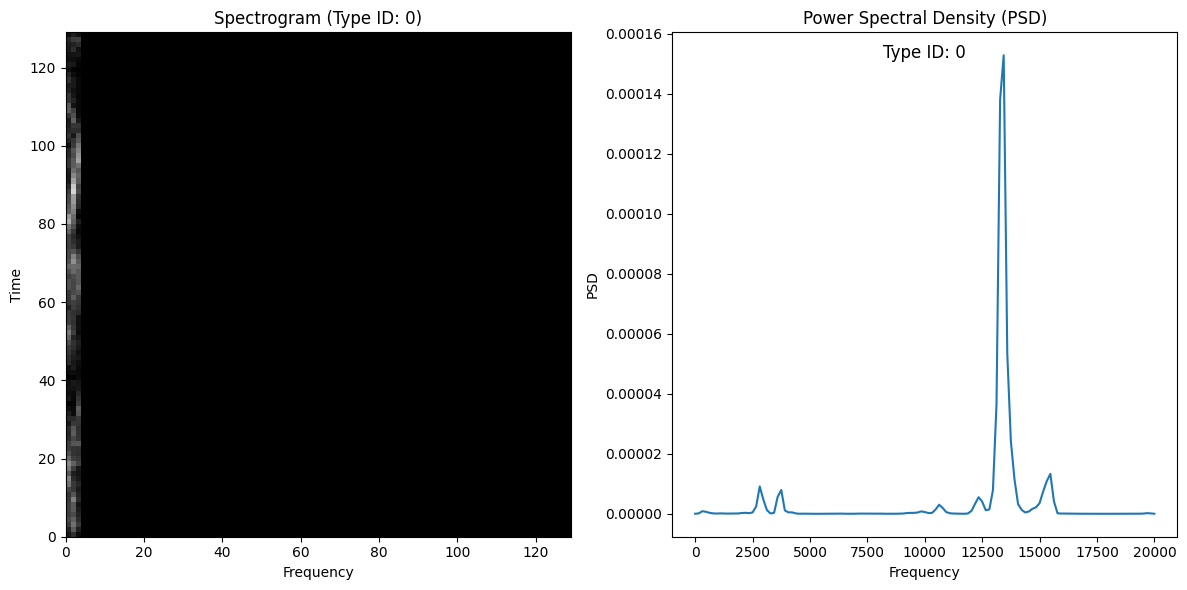

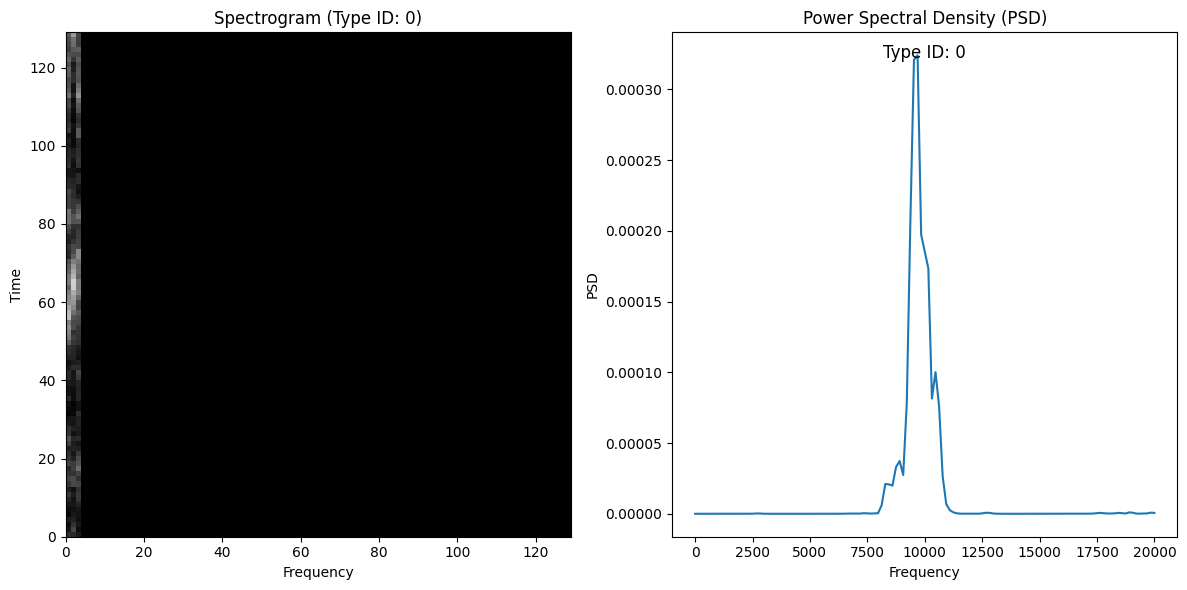

In [12]:
import random

# Assuming df_fft is your DataFrame
random_indices = random.sample(range(len(df_fft)), k=3)
random_samples = df_fft.iloc[random_indices]

for index, row in random_samples.iterrows():
    frequencies = row['frequencies']
    magnitudes = row['magnitudes']
    spectrogram = row['spectrogram']
    type_id = row['type_id']
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    
    # Plot the spectrogram on the left side
    ax[0].imshow(spectrogram, aspect='auto', origin='lower', extent=[0, len(frequencies), 0, len(magnitudes)])
    ax[0].set_title(f'Spectrogram (Type ID: {type_id})')
    ax[0].set_xlabel('Frequency')
    ax[0].set_ylabel('Time')
    
    ax[1].plot(frequencies, magnitudes)
    ax[1].set_title('Power Spectral Density (PSD)')
    ax[1].set_xlabel('Frequency')
    ax[1].set_ylabel('PSD')

    # Add type_id as text on the plots
    ax[0].text(0.5, 0.95, f'Type ID: {type_id}', transform=ax[0].transAxes, ha='center', fontsize=12)
    ax[1].text(0.5, 0.95, f'Type ID: {type_id}', transform=ax[1].transAxes, ha='center', fontsize=12)
    
    plt.tight_layout()
    plt.show()

In [13]:
 df_fft['spectrogram'].iloc[0].shape

(100, 100, 3)

In [20]:
from torchsummary import summary
from torch import nn
import torch
import torch.nn.functional as F

# Build CNN model
# Define a VGG-like neural network class
# Define a basic block for ResNet
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

# Define the ResNet architecture
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=2):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        layers = []
        strides = [stride] + [1] * (num_blocks - 1)
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

def ResNet18(num_classes=2):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)

#print("Model summary : ")
#print(summary(ResNet, (3, df_fft['spectrogram'].iloc[0].shape[0], df_fft['spectrogram'].iloc[0].shape[1])))

In [21]:
from torch.utils.data import Dataset

class SpectrogramDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        spectrogram = self.data['spectrogram'].iloc[idx]
        type_id = self.data['type_id'].iloc[idx]
        # Przykładowe przekształcenie danych - konwersja na tensor
        spectrogram_tensor = torch.tensor(spectrogram, dtype=torch.float32)
        return spectrogram_tensor, type_id

In [22]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

train_df, test_df = train_test_split(df_fft, test_size=0.4, random_state=42)

train_dataset = SpectrogramDataset(train_df)
test_dataset = SpectrogramDataset(test_df)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [23]:
next(iter(train_loader))[0].size()

torch.Size([28, 100, 100, 3])

In [24]:
from tqdm.auto import tqdm

# Training and validation loops remain the same
def train_loop(dataloader, model, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in dataloader:
        inputs = inputs.permute(0, 3, 1, 2)  # Adjust input format to (N, C, H, W)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(dataloader)
    train_accuracy = correct / total
    return train_loss, train_accuracy

def valid_loop(dataloader, model, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.permute(0, 3, 1, 2)  # Adjust input format to (N, C, H, W)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    valid_loss = running_loss / len(dataloader)
    valid_accuracy = correct / total
    return valid_loss, valid_accuracy


In [25]:
from tqdm.auto import tqdm

# Definicja modelu, funkcji straty i optymalizatora
model = ResNet18(num_classes=2)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Przykład użycia pętli uczącej i walidacyjnej przez kilka epok
num_epochs = 41
for epoch in tqdm(range(num_epochs)):
    train_loss, train_accuracy = train_loop(train_loader, model, criterion, optimizer)
    valid_loss, valid_accuracy = valid_loop(test_loader, model, criterion)

    if epoch %4 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {100*train_accuracy:.2f}%, '
              f'Valid Loss: {valid_loss:.4f}, Valid Accuracy: {100*valid_accuracy:.2f}%')

  0%|          | 0/41 [00:00<?, ?it/s]

Epoch 1/41, Train Loss: 0.6494, Train Accuracy: 96.43%, Valid Loss: 0.1739, Valid Accuracy: 100.00%
Epoch 5/41, Train Loss: 0.0041, Train Accuracy: 100.00%, Valid Loss: 0.0000, Valid Accuracy: 100.00%
Epoch 9/41, Train Loss: 0.0010, Train Accuracy: 100.00%, Valid Loss: 0.0000, Valid Accuracy: 100.00%
Epoch 13/41, Train Loss: 0.0004, Train Accuracy: 100.00%, Valid Loss: 0.0000, Valid Accuracy: 100.00%
Epoch 17/41, Train Loss: 0.0002, Train Accuracy: 100.00%, Valid Loss: 0.0000, Valid Accuracy: 100.00%
Epoch 21/41, Train Loss: 0.0001, Train Accuracy: 100.00%, Valid Loss: 0.0000, Valid Accuracy: 100.00%
Epoch 25/41, Train Loss: 0.0001, Train Accuracy: 100.00%, Valid Loss: 0.0000, Valid Accuracy: 100.00%
Epoch 29/41, Train Loss: 0.0001, Train Accuracy: 100.00%, Valid Loss: 0.0000, Valid Accuracy: 100.00%
Epoch 33/41, Train Loss: 0.0001, Train Accuracy: 100.00%, Valid Loss: 0.0000, Valid Accuracy: 100.00%
Epoch 37/41, Train Loss: 0.0001, Train Accuracy: 100.00%, Valid Loss: 0.0000, Valid Ac